# ANN & WORD EMBEDDINGS

## IMPORT PACKAGES & FUNCTIONS

In [1]:
import re
import numpy as np
import pandas as pd
from nltk import WordNetLemmatizer
import keras
from keras.preprocessing.text import Tokenizer
!pip install keras_preprocessing
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, GRU
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import nltk 
import pickle
from pickle import load
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from nltk import download
download('wordnet')
download('omw-1.4')
download('stopwords')
import tensorflow
import gensim
import gensim.downloader as api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


TEXT PREPROCESSING

There are two text preprocessing methods:
 
1.    **Simple text preprocessing**: simple form of pre-processing including filtering with regex, stopword removal and dimensionality reduction with lemmatisation
2.   **Complex text preprocessing**: Stricter text pre-processing. Include transformation of contractions and grammatical derivations into their full form. The changes come from observations made with Knowledge Graphs for Increment 4.



In [42]:
# SIMPLE TEXT PREPROCESSING
def preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^0-9a-z_+\-*]', ' ', text).strip()
    lemm = WordNetLemmatizer()
    title = []
    for token in text.split():
        title.append(token)
    return ' '.join(str(elem) for elem in title)

In [49]:
# COMPLEX TEXT PREPROCESSING
contr = {
    "aren't": "are not",
    "she'd": "she had",
    "can't": "cannot",
    "shouldn't": "should not",
    "couldn't": "could not",
    "that's": "that is",
    "didn't": "did not",
    "there's": "there is",
    "don't": "do not",
    "they're": "they are",
    "doesn't": "does not",
    "they've": "they have",
    "hadn't": "had not",
    "they'll": "they will",
    "haven't": "have not",
    "they'd": "they would",
    "he's": "he is",
    "they'd": "they had",
    "he's": "he has",
    "wasn't": "was not",
    "he'll": "he will",
    "we're": "we are",
    "he'd": "he would",
    "we've": "we have",
    "here's": "here is",
    "we'll": "we will",
    "i'm": "I am",
    "we'd": "we would",
    "i've": "I have",
    "we'd": "we had",
    "i'll": "I will",
    "weren't": "were not",
    "i'd": "I would",
    "what's": "what is",
    "i'd": "I had",
    "where's": "where is",
    "isn't": "is not",
    "who's": "who is",
    "it's": "it is",
    "who'll": "who will",
    "it's": "it has",
    "won't": "will not",
    "it's": "it has",
    "wouldn't": "would not",
    "it'll": "it will",
    "you're": "you are",
    "mustn't": "must not",
    "you've": "you have",
    "she's": "she is",
    "you'll": "you will",
    "she's": "she has",
    "you'd": "you would",
    "she'll": "she will",
    "you'd": "you had",
    "she'd": "she would"
}
capitonyms = {
    "US": "the United States of America",
    "Turkey": "turkish country",
    "Fiat": "the italian automobile manufacturer",
    "Conservative": "member of the conservative party",
    "Cat": "Catherine",
    "AM": "ante Meridiem"
}
abbreviations = {
    #"&": "and",
    #"$": "dollars",
    "dr.": "doctor",
    "assoc.": "association",
    "sr.": "senior",
    "st.": "saint"
}
def expand_dict(s, dict):
    exp = re.compile('(%s)' % '|'.join(dict.keys()))
    def replace(matcher):
        return dict[matcher.group(0)]
    return exp.sub(replace, s)
def preprocessing(text):
    text_c = expand_dict(text, capitonyms)
    text = text_c.lower()
    text_co = expand_dict(text, contr)
    text_cleaned = re.sub(r'[^0-9a-z_+\-*]', ' ', text_co).strip()
    lemm = WordNetLemmatizer()
    title = []
    for token in text_cleaned.split():
        token_lemm = lemm.lemmatize(token)
        if token_lemm not in stopwords.words('english'):
             title.append(lemm.lemmatize(token))
    return ' '.join(str(elem) for elem in title)


##IMPORT DATA FROM LOCAL FILES
Files to upload:
- test_category.csv
- test_data.csv
- train_category.csv
- train_data.csv

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test_category.csv to test_category.csv
Saving test_data.csv to test_data.csv
Saving train_category.csv to train_category.csv
Saving train_data.csv to train_data.csv


## MODEL EVALUATION METRICS

In [5]:
def my_confusion_matrix(test_label, label_pred, model_name):
    labels = ['b', 'e', 'm', 't']
    conf = confusion_matrix(test_label, label_pred)
    cmd_obj = ConfusionMatrixDisplay(conf, display_labels=labels)
    cmd_obj.plot()
    cmd_obj.ax_.set(xlabel='Predicciones', ylabel='Valores reales')
    plt.title(f'Confussion matrix: {model_name}')
    plt.show()


def my_evaluation(test_label, label_pred, model_name):
    print(f"************* METRICS AVERAGE: {model_name} *************")
    print("Accuracy: ", accuracy_score(label_pred, test_label) * 100)
    print("Precision: ", precision_score(label_pred, test_label, average='macro') * 100)
    print("Recall: ", recall_score(label_pred, test_label, average='macro') * 100)
    print("f1: ", f1_score(label_pred, test_label, average='macro') * 100)
    print()
    print(f"************* METRICS BY CATEGORY {model_name} *************")
    print("Precision by cat.: ", precision_score(label_pred, test_label, average=None) * 100)
    print("Recall by cat.: ", recall_score(label_pred, test_label, average=None) * 100)
    print("f1 by cat.: ", f1_score(label_pred, test_label, average=None) * 100)
    print()

In [6]:
train_data_df = pd.read_csv('/content/train_data.csv')
test_data_df = pd.read_csv('/content/test_data.csv')
train_label_df = pd.read_csv('/content/train_category.csv')
test_label_df = pd.read_csv('/content/test_category.csv')

In [7]:
train_data = train_data_df['headline']
test_data = test_data_df['headline']
train_label = train_label_df['labels'] 
test_label = test_label_df['labels']

## DATA PREPARATION

In [50]:
train_data = train_data.apply(lambda x: preprocessing(str(x)))
test_data = test_data.apply(lambda x: preprocessing(str(x)))

In [51]:
labels = ['b', 'e', 'm', 't']
vocab_size = 116900
max_token = 20 
data_tokenizer = Tokenizer(num_words=vocab_size+1)
label_tokenizer = Tokenizer()
data_tokenizer.fit_on_texts(train_data)
label_tokenizer.fit_on_texts(labels)

In [52]:
train_data_sequences = data_tokenizer.texts_to_sequences(train_data)
test_data_sequences = data_tokenizer.texts_to_sequences(test_data)
train_label_sequences = label_tokenizer.texts_to_sequences(train_label)
test_label_sequences = label_tokenizer.texts_to_sequences(test_label)

In [53]:
train_data_pad = pad_sequences(train_data_sequences, maxlen=max_token, padding='pre', truncating='pre')
test_data_pad = pad_sequences(test_data_sequences, maxlen=max_token, padding='pre', truncating='pre')
train_label_pad = np.array(train_label_sequences)
test_label_pad = np.array(test_label_sequences)

## WORD EMBEDDING IMPORT
- word2vec: imported from Gensim
- glove: local file 'glove.6B.300d.txt'

In [23]:
w2v_model = api.load('word2vec-google-news-300')

[=================================================-] 99.8% 1659.3/1662.8MB downloaded


In [14]:
#from google.colab import files
#uploaded = files.upload()
gloVe_path = '/content/glove.6B.300d.txt'

In [15]:
# Setting variables for the model
embed_dim = 300
max_len=20
vocab_size= len(data_tokenizer.word_index) + 1

In [38]:
# word2vec ---> VOCAB MATRIX
def word_emb_w2v(w2v_model=w2v_model):
  vocab = list(w2v_model.index_to_key)
  #words = list(model.wv.index_to_key)
  word_vec_dict={}
  for word in vocab:
    word_vec_dict[word] = w2v_model.get_vector(word)
  embedding_matrix = get_embed_matrix(word_vec_dict)
  return embedding_matrix

In [27]:
# GloVe ---> VOCAB MATRIX
def word_emb_glove(gloVe_path=gloVe_path):
  word_vec_dict = {}
  file_reader = open(gloVe_path, 'r', encoding='utf-8')
  for vect in file_reader:
      values = vect.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      word_vec_dict[word] = coefs
  file_reader.close()
  embedding_matrix = get_embed_matrix(word_vec_dict)
  return embedding_matrix


In [28]:
# create embed matrix
def get_embed_matrix(word_vec_dict):
  embedding_matrix = np.zeros(shape=(vocab_size, embed_dim))
  for word, i in data_tokenizer.word_index.items():
    embed_vector = word_vec_dict.get(word)
    if embed_vector is not None:
      embedding_matrix[i] = embed_vector
  return embedding_matrix

In [29]:
def build_model(word_emb, rnn_layer, embedding_matrix):
  if word_emb == True:
    embedding_initializer = tensorflow.constant_initializer(embedding_matrix)
  else:
    # default value
    embedding_initializer = 'uniform'
  if rnn_layer == 'lstm':
    rnn = LSTM(450)
  else:
    # default value
    rnn = GRU(450)
  
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len, embeddings_initializer=embedding_initializer))
  model.add(Dropout(0.5))
  model.add(Bidirectional(rnn))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

## EXECUTION OF MODELS

In [47]:
epochs = 4
batch_size = 32
embedding_matrix_glove = word_emb_glove()
embedding_matrix_w2v = word_emb_w2v()
models = {
    "LSTM": build_model(False, 'lstm', None),
    "GRU": build_model(False, 'gru', None),
    "WORD2VEC-LSTM": build_model(True, 'lstm', embedding_matrix_w2v),
    "WORD2VEC-GRU": build_model(True, 'gru', embedding_matrix_w2v),
    "GLOVE-LSTM": build_model(True, 'lstm', embedding_matrix_glove),
    "GLOVE-GRU": build_model(True, 'gru', embedding_matrix_glove)
}

Epoch 1/4
743/743 [==============================] - 20s 27ms/step - loss: 0.6824 - accuracy: 0.7239
Epoch 2/4
743/743 [==============================] - 20s 27ms/step - loss: 0.1766 - accuracy: 0.9420
Epoch 3/4
743/743 [==============================] - 20s 27ms/step - loss: 0.0914 - accuracy: 0.9699
Epoch 4/4
40/40 [==============================] - 0s 6ms/step
************* METRICS AVERAGE: LSTM *************
Accuracy:  90.88000000000001
Precision:  90.82027149077962
Recall:  90.89635761764504
f1:  90.76716992858577

************* METRICS BY CATEGORY LSTM *************
Precision by cat.:  [82.60869565 93.97590361 95.1048951  91.59159159]
Recall by cat.:  [91.82156134 93.69369369 88.88888889 89.18128655]
f1 by cat.:  [86.97183099 93.83458647 91.89189189 90.37037037]



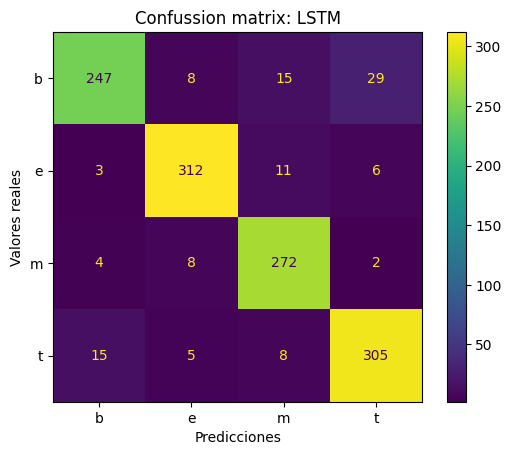

Epoch 1/4
743/743 [==============================] - 19s 26ms/step - loss: 0.5807 - accuracy: 0.7815
Epoch 2/4
743/743 [==============================] - 19s 26ms/step - loss: 0.1496 - accuracy: 0.9504
Epoch 3/4
743/743 [==============================] - 19s 26ms/step - loss: 0.0807 - accuracy: 0.9731
Epoch 4/4
40/40 [==============================] - 0s 3ms/step
************* METRICS AVERAGE: GRU *************
Accuracy:  90.24
Precision:  90.14970384470124
Recall:  90.2725008980616
f1:  90.1520770286795

************* METRICS BY CATEGORY GRU *************
Precision by cat.:  [83.27759197 93.07228916 92.65734266 91.59159159]
Recall by cat.:  [91.20879121 91.69139466 89.52702703 88.6627907 ]
f1 by cat.:  [87.06293706 92.37668161 91.0652921  90.10339734]



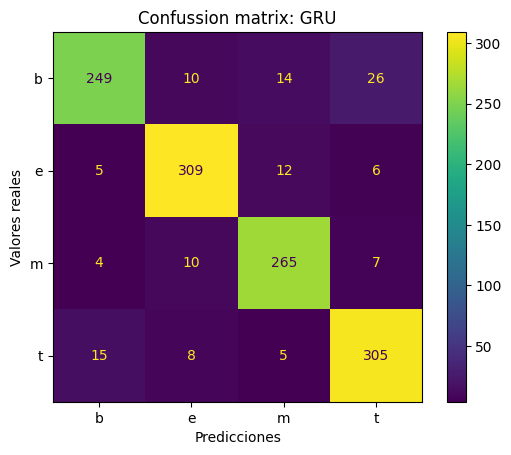

Epoch 1/4
743/743 [==============================] - 20s 27ms/step - loss: 0.8674 - accuracy: 0.6253
Epoch 2/4
743/743 [==============================] - 20s 27ms/step - loss: 0.2578 - accuracy: 0.9117
Epoch 3/4
743/743 [==============================] - 20s 27ms/step - loss: 0.1514 - accuracy: 0.9496
Epoch 4/4
40/40 [==============================] - 0s 4ms/step
************* METRICS AVERAGE: WORD2VEC-LSTM *************
Accuracy:  92.0
Precision:  92.03329874820184
Recall:  91.93377060319825
f1:  91.96782353097234

************* METRICS BY CATEGORY WORD2VEC-LSTM *************
Precision by cat.:  [88.9632107  93.6746988  95.1048951  90.39039039]
Recall by cat.:  [90.47619048 93.95770393 90.96989967 92.33128834]
f1 by cat.:  [89.71332209 93.81598793 92.99145299 91.35053111]



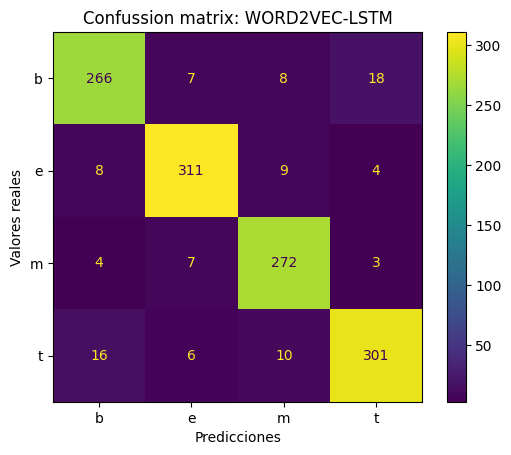

Epoch 1/4
743/743 [==============================] - 19s 26ms/step - loss: 0.7324 - accuracy: 0.7019
Epoch 2/4
743/743 [==============================] - 19s 26ms/step - loss: 0.2221 - accuracy: 0.9242
Epoch 3/4
743/743 [==============================] - 19s 26ms/step - loss: 0.1391 - accuracy: 0.9537
Epoch 4/4
40/40 [==============================] - 0s 3ms/step
************* METRICS AVERAGE: WORD2VEC-GRU *************
Accuracy:  91.28
Precision:  91.38851669954342
Recall:  91.43138930668135
f1:  91.30466424712888

************* METRICS BY CATEGORY WORD2VEC-GRU *************
Precision by cat.:  [93.64548495 90.6626506  92.65734266 88.58858859]
Recall by cat.:  [84.08408408 97.72727273 92.01388889 91.90031153]
f1 by cat.:  [88.60759494 94.0625     92.33449477 90.21406728]



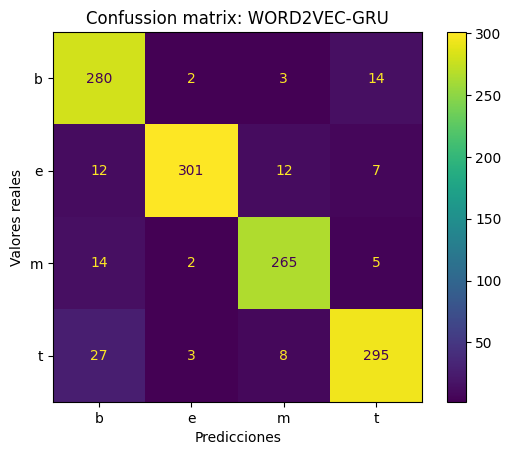

Epoch 1/4
743/743 [==============================] - 20s 27ms/step - loss: 1.0307 - accuracy: 0.5488
Epoch 2/4
743/743 [==============================] - 20s 27ms/step - loss: 0.3732 - accuracy: 0.8677
Epoch 3/4
743/743 [==============================] - 20s 27ms/step - loss: 0.2337 - accuracy: 0.9185
Epoch 4/4
40/40 [==============================] - 0s 3ms/step
************* METRICS AVERAGE: GLOVE-LSTM *************
Accuracy:  91.84
Precision:  91.84094738377085
Recall:  91.78310336965718
f1:  91.79186690488417

************* METRICS BY CATEGORY GLOVE-LSTM *************
Precision by cat.:  [88.29431438 93.07228916 94.40559441 91.59159159]
Recall by cat.:  [89.79591837 96.26168224 90.30100334 90.77380952]
f1 by cat.:  [89.03878583 94.64012251 92.30769231 91.18086697]



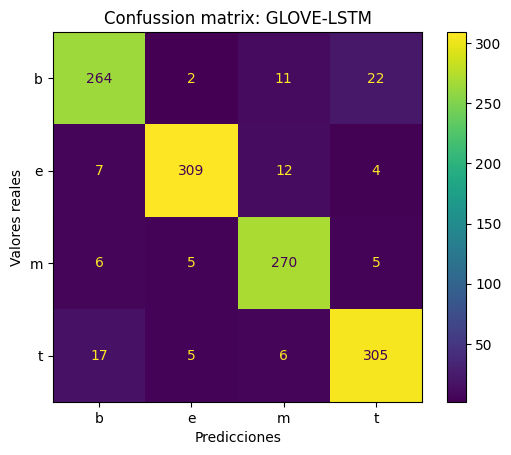

Epoch 1/4
743/743 [==============================] - 19s 26ms/step - loss: 0.9245 - accuracy: 0.6061
Epoch 2/4
743/743 [==============================] - 20s 26ms/step - loss: 0.3398 - accuracy: 0.8821
Epoch 3/4
743/743 [==============================] - 19s 26ms/step - loss: 0.2185 - accuracy: 0.9246
Epoch 4/4
40/40 [==============================] - 0s 3ms/step
************* METRICS AVERAGE: GLOVE-GRU *************
Accuracy:  92.56
Precision:  92.58511355813607
Recall:  92.57934745162537
f1:  92.58030330260296

************* METRICS BY CATEGORY GLOVE-GRU *************
Precision by cat.:  [89.96655518 94.57831325 95.1048951  90.69069069]
Recall by cat.:  [91.18644068 94.86404834 94.11764706 90.14925373]
f1 by cat.:  [90.57239057 94.72096531 94.60869565 90.41916168]



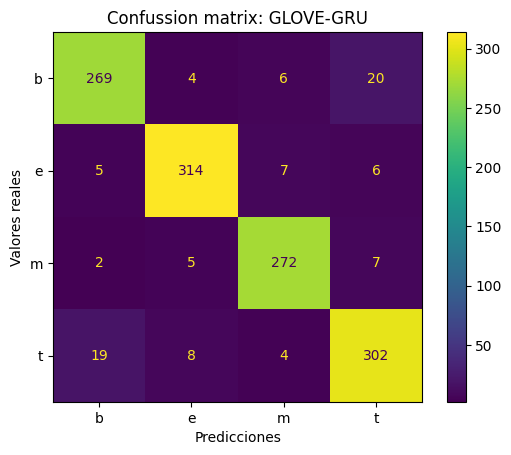

In [54]:
for model in models:
  models[model].fit(train_data_pad, train_label_pad, epochs=epochs, batch_size=batch_size)
  label_prediction = models[model].predict(test_data_pad)
  label_pred = np.argmax(label_prediction, axis=1)
  my_evaluation(test_label_pad, label_pred, model)
  my_confusion_matrix(test_label_pad, label_pred, model)